**Load all the features saved as numpy array**

In [ ]:
# Load the pre-extracted image features and question embeddings.
# This retrieves the saved feature arrays from the previous steps.
# Loading these features allows us to proceed with model training without re-extracting them.

train_features = np.load("train_features.npy")  # (num_train_samples, 2048)
val_features = np.load("val_features.npy")  # (num_val_samples, 2048)

map image feature for each question row to get the same sampled dataset

In [ ]:
# Map image features to each question row based on image ID.
# This ensures that each question in the filtered DataFrames is associated with its corresponding image features.
# It handles cases where the order of questions might not match the order of extracted image features.

#Load features from filtered image IDs
train_image_features = dict(zip(df_train_filtered['image_id'], train_features)) # Create a dictionary for train features
val_image_features = dict(zip(df_val_filtered['image_id'], val_features)) # Create a dictionary for val features

# Function to get the image feature for each question row
def get_image_features_for_questions(df, image_features_dict):
    image_features = []
    for img_id in df['image_id']:
        image_features.append(image_features_dict.get(img_id, np.zeros(2048)))  # Default to zero if missing
    return np.array(image_features)

# Get the image features for the filtered train and val question rows
train_image_features_for_questions = get_image_features_for_questions(df_train_filtered, train_image_features)
val_image_features_for_questions = get_image_features_for_questions(df_val_filtered, val_image_features)

# Print out the shapes to confirm they match the number of rows
print(f"Train Image Features Shape: {train_image_features_for_questions.shape}")
print(f"Val Image Features Shape: {val_image_features_for_questions.shape}")

Train Image Features Shape: (53389, 2048)
Val Image Features Shape: (26769, 2048)


In [ ]:
train_question_embeddings = np.load("bert_embeddings_train.npy")  # (num_train_samples, 768)
train_answers = np.load("train_answers.npy")

In [ ]:
val_question_embeddings = np.load("bert_embeddings_val.npy")  # (num_val_samples, 768)
val_answers = np.load("val_answers.npy")  # (num_val_samples, 181)

# Model Architectures and training


**Approach 4: Fusion with Modality Dropout, Attention Fusion, Transformer Block, and Residual Connections**


Model Architecture Description (Approach 4):

This advanced fusion model incorporates several sophisticated techniques. It begins by projecting both image and text features to a common embedding dimension (512). Modality Dropout is then applied during training, randomly dropping out either the image or text features for each sample to encourage the model to learn robust representations from each modality independently. The processed features are then fed into an Attention Fusion Layer, which uses multi-head self-attention to learn the relationships and importance between the visual and textual features. The output of this layer is passed through a Transformer Block, further enhancing the representation learning capabilities. Finally, a few dense layers with dropout are used before the softmax output layer for classification. This architecture aims to capture intricate interactions between modalities and improve generalization.

Hyperparameters Tuned (Approach 4):

Learning Rate: Set to 0.00005 for the Adam optimizer.
Number of Epochs: Set to 25.
Batch Size: Set to 64.
Embedding Dimension: Set to 512 for the projected image and text features, as well as within the attention and transformer layers.
Number of Attention Heads: Set to 8 in both the Attention Fusion Layer and the Transformer Block. This allows the attention mechanism to focus on different parts of the input features simultaneously.
Feed-Forward Dimension (Transformer): Set to 512 in the Transformer Block. This controls the size of the intermediate representation in the feed-forward network.
Dropout Rates: Dropout is used in multiple layers (Modality Dropout, Attention Fusion, Transformer Block, and final dense layers) with rates of 0.2, 0.1, 0.1, and 0.3 respectively. These help prevent overfitting.

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 2048)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_input (InputLayer)   │ (None, 768)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_projection (Dense)  │ (None, 512)            │      1,049,088 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_projection (Dense)   │ (None, 512)            │        393,728 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ modality_dropout          │ [(None, 512), (None,   │              0 │ image_projection[0][0… │
│ (ModalityDropout)         │ 512)]                  │                │ text_projection[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_fusion_layer    │ (None, 512)            │      8,402,432 │ modality_dropout[0][0… │
│ (AttentionFusionLayer)    │                        │                │ modality_dropout[0][1] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block         │ (None, 512)            │      8,928,768 │ attention_fusion_laye… │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 512)            │        262,656 │ transformer_block[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 512)            │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 181)            │         92,853 │ dropout_8[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 19,129,525 (72.97 MB)

 Trainable params: 19,129,525 (72.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 58s 53ms/step - accuracy: 0.2925 - loss: 3.0818 - val_accuracy: 0.3946 - val_loss: 2.1250
Epoch 2/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 67s 43ms/step - accuracy: 0.3624 - loss: 2.2214 - val_accuracy: 0.4210 - val_loss: 1.8857
Epoch 3/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.3837 - loss: 2.0302 - val_accuracy: 0.4348 - val_loss: 1.7522
Epoch 4/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 36s 43ms/step - accuracy: 0.3978 - loss: 1.9258 - val_accuracy: 0.4469 - val_loss: 1.6738
Epoch 5/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.4145 - loss: 1.8421 - val_accuracy: 0.4583 - val_loss: 1.6177
Epoch 6/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.4246 - loss: 1.7813 - val_accuracy: 0.4622 - val_loss: 1.5831
Epoch 7/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4334 - loss: 1.7387 - val_accuracy: 0.4725 - val_loss: 1.5442
Epoch 8/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4359 - loss: 1.6964 - 

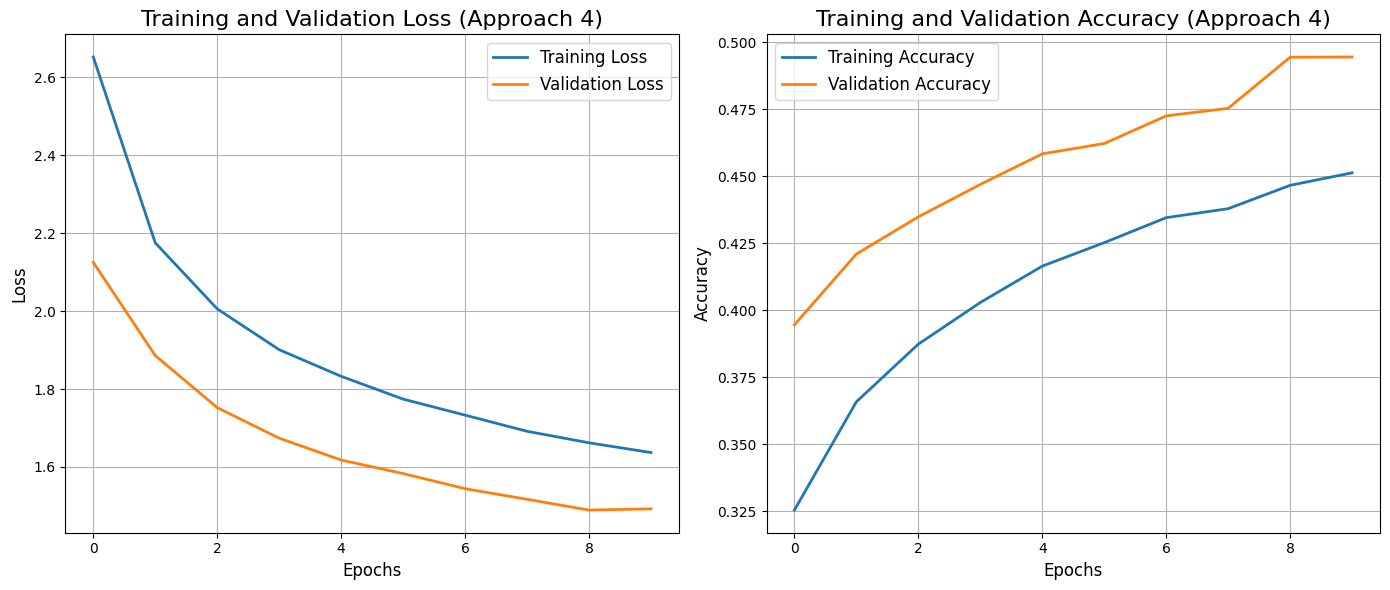

837/837 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4950 - loss: 1.4908

Approach 4 Validation Loss: 1.4924
Approach 4 Validation Accuracy: 0.4945


In [ ]:
# Define and train a more advanced fusion model incorporating modality dropout, attention, and transformer blocks.
# This architecture aims to leverage the strengths of attention mechanisms and transformer networks for better feature fusion and representation learning.
# Modality dropout is used to improve robustness by randomly dropping out one of the modalities during training.

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, MultiHeadAttention, Input, Add
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Attention Fusion Layer
class AttentionFusionLayer(tf.keras.layers.Layer):
    def __init__(self, embed_dim=512, num_heads=4, dropout_rate=0.1):
        super(AttentionFusionLayer, self).__init__()
        self.multihead_attn = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dropout = Dropout(dropout_rate)
        self.norm = LayerNormalization(epsilon=1e-6)

    def call(self, image_features, text_features):
        # Instead of concatenating along feature dimension, stack along a new axis:
        # image_features and text_features: (batch, 512)
        combined_features = tf.stack([image_features, text_features], axis=1)  # Shape: (batch, 2, 512)

        # Apply multi-head self-attention (provide query, key, value)
        attn_output = self.multihead_attn(query=combined_features,
                                            key=combined_features,
                                            value=combined_features)
        attn_output = self.dropout(attn_output)

        # Residual connection and layer normalization
        fused = self.norm(combined_features + attn_output)  # (batch, 2, 512)

        # Aggregate over the sequence dimension (e.g., take mean) to obtain a single fused vector.
        fused = tf.reduce_mean(fused, axis=1)  # Now shape is (batch, 512)
        return fused

# Transformer Block (Modified for Vector Input)
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim=512, num_heads=4, ff_dim=512, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs):
        # inputs: (batch, embed_dim) --> add sequence dimension
        x = tf.expand_dims(inputs, axis=1)  # (batch, 1, embed_dim)

        # Apply multi-head attention
        attn_output = self.att(query=x, key=x, value=x)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(x + attn_output)  # (batch, 1, embed_dim)

        # Feed-forward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)  # (batch, 1, embed_dim)

        # Squeeze the sequence dimension back out.
        return tf.squeeze(out2, axis=1)  # (batch, embed_dim)

class ModalityDropout(tf.keras.layers.Layer):
    def __init__(self, dropout_rate=0.2):
        super(ModalityDropout, self).__init__()
        self.dropout_rate = dropout_rate

    def call(self, image_features, text_features, training=True):
        # Apply dropout based on training flag
        if training:
            # Create a mask with a shape compatible with both image and text features
            mask_shape = tf.shape(image_features)  # or tf.shape(text_features) - they should be compatible

            # Generate a random mask for dropout
            mask = tf.random.uniform(mask_shape, dtype=tf.float32) > self.dropout_rate
            mask = tf.cast(mask, tf.float32)

            # Randomly zero out either image or text features
            image_features = image_features * mask
            text_features = text_features * (1 - mask) # If image is kept, text is dropped and vice versa

        return image_features, text_features

# Define input layers
image_input = Input(shape=(2048,), name="image_input")
text_input = Input(shape=(768,), name="text_input")

# Project to a common dimension
image_proj = Dense(512, activation='relu', name="image_projection")(image_input)
text_proj = Dense(512, activation='relu', name="text_projection")(text_input)

# Modality Dropout
modality_dropout = ModalityDropout(dropout_rate=0.2)
image_drop, text_drop = modality_dropout(image_proj, text_proj)

# Attention Fusion
attention_fusion = AttentionFusionLayer(embed_dim=512, num_heads=8, dropout_rate=0.1)(image_drop, text_drop)

# Transformer Block
transformer_block = TransformerBlock(embed_dim=512, num_heads=8, ff_dim=512, dropout_rate=0.1)(attention_fusion)

# Final Dense Layers
fc1 = Dense(512, activation='relu')(transformer_block)
dropout = Dropout(0.3)(fc1)
output = Dense(num_classes, activation='softmax')(dropout)

# Define the model
model_approach4 = Model(inputs=[image_input, text_input], outputs=output)

# Compile the model
model_approach4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Model Summary
model_approach4.summary()

# Train the model
history_approach4 = model_approach4.fit(
    x=[X_train_image, X_train_text],
    y=train_answers,
    validation_data=([X_val_image, X_val_text], val_answers),
    epochs=10,
    batch_size=64,
    verbose=1
)

# Plot training and validation loss and accuracy
plt.figure(figsize=(14, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_approach4.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_approach4.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss (Approach 4)', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_approach4.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history_approach4.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy (Approach 4)', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate the model
val_loss_approach4, val_accuracy_approach4 = model_approach4.evaluate([X_val_image, X_val_text], val_answers, verbose=1)
print(f'\nApproach 4 Validation Loss: {val_loss_approach4:.4f}')
print(f'Approach 4 Validation Accuracy: {val_accuracy_approach4:.4f}')

## **Tuned Model**

Tubed Changes Summary:

- Bidirectional Cross-Modal Attention - Instead of stacking features and using self-attention, we now use explicit cross-attention between image and text modalities in both directions.
- Improved Normalization - Added LayerNormalization throughout the network for better training stability.
- Expanded Transformer Capacity - Doubled the feed-forward network dimension in transformer blocks (from 512 to 1024).
- GELU Activations - Changed all activations from ReLU to GELU for better performance with transformer components.
- Deeper Classification Network - Added an intermediate layer in the classification head.
- Tuned Hyperparameters:

  - Increased dropout from 0.1 to 0.15
  - Reduced learning rate from 1e-4 to 5e-5
  - Increased label smoothing from 0.05 to 0.1
  - Increased early stopping and LR reduction patience

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, MultiHeadAttention, Input, Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import TopKCategoricalAccuracy

# --- Cross-Modal Attention Fusion Layer ---
class CrossModalAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, embed_dim=512, num_heads=8, dropout_rate=0.15):
        super().__init__()
        self.img2text_attn = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads)
        self.text2img_attn = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads)
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(dropout_rate)
        self.dense = Dense(embed_dim)

    def call(self, image_features, text_features):
        # Expand dimensions for attention
        img_expanded = tf.expand_dims(image_features, axis=1)
        txt_expanded = tf.expand_dims(text_features, axis=1)

        # Bidirectional attention
        img_attended = self.img2text_attn(query=img_expanded, key=txt_expanded, value=txt_expanded)
        txt_attended = self.text2img_attn(query=txt_expanded, key=img_expanded, value=img_expanded)

        # Combine with residuals
        img_enhanced = self.norm1(img_expanded + img_attended)
        txt_enhanced = self.norm2(txt_expanded + txt_attended)

        # Combine modalities
        fused = tf.concat([tf.squeeze(img_enhanced, 1), tf.squeeze(txt_enhanced, 1)], axis=-1)
        fused = self.dense(fused)
        fused = self.dropout(fused)

        return fused

# --- Transformer Block ---
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim=512, num_heads=8, ff_dim=1024, dropout_rate=0.15):
        super().__init__()
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="gelu"),
            Dropout(dropout_rate),
            Dense(embed_dim)
        ])
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs):
        x = tf.expand_dims(inputs, axis=1)
        attn_output = self.attn(query=x, key=x, value=x)
        out1 = self.norm1(x + self.dropout1(attn_output))
        ffn_output = self.ffn(out1)
        out2 = self.norm2(out1 + self.dropout2(ffn_output))
        return tf.squeeze(out2, axis=1)

# --- Hyperparameters ---
hidden_dim = 512
num_classes = 181
dropout_rate = 0.15

# --- Inputs ---
image_input = Input(shape=(2048,), name="image_input")
text_input = Input(shape=(768,), name="text_input")

# --- Project image and text features with Layer Norm ---
image_proj = Dense(hidden_dim, activation='gelu')(image_input)
image_proj = LayerNormalization(epsilon=1e-6)(image_proj)
text_proj = Dense(hidden_dim, activation='gelu')(text_input)
text_proj = LayerNormalization(epsilon=1e-6)(text_proj)

# --- Cross-modal attention fusion ---
fused = CrossModalAttentionLayer(embed_dim=hidden_dim, num_heads=8, dropout_rate=dropout_rate)(image_proj, text_proj)

# --- Transformer Blocks with larger FFN ---
transformed = TransformerBlock(embed_dim=hidden_dim, num_heads=8, ff_dim=hidden_dim*2, dropout_rate=dropout_rate)(fused)
transformed = TransformerBlock(embed_dim=hidden_dim, num_heads=8, ff_dim=hidden_dim*2, dropout_rate=dropout_rate)(transformed)

# --- Residual connection (fused → transformed) ---
fused_output = Add()([transformed, fused])

# --- Deeper output network ---
fc = Dense(hidden_dim, activation='gelu')(fused_output)
fc = LayerNormalization(epsilon=1e-6)(fc)
fc = Dropout(dropout_rate)(fc)
fc = Dense(hidden_dim//2, activation='gelu')(fc)
fc = Dropout(dropout_rate)(fc)
output = Dense(num_classes, activation='softmax')(fc)

# --- Build the model ---
model_approach4_tuned = Model(inputs=[image_input, text_input], outputs=output)

# --- Compile with label smoothing ---
model_approach4_tuned.compile(
    optimizer=Adam(learning_rate=5e-5),  # Lower learning rate
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),  # Increased label smoothing
    metrics=['accuracy', TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
)

# --- Callbacks with longer patience ---
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),  # Increased patience
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)  # Increased patience
]

# --- Train the model ---
history_approach4_tuned = model_approach4_tuned.fit(
    x=[X_train_image, X_train_text],
    y=train_answers,
    validation_data=([X_val_image, X_val_text], val_answers),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# --- Evaluate on validation set ---
val_loss_4_tuned, val_acc_4_tuned, val_top3_4_tuned = model_approach4_tuned.evaluate([X_val_image, X_val_text], val_answers, verbose=1)
print(f"\nApproach 4 (Tuned) Validation Accuracy: {val_acc_4_tuned:.4f}")
print(f"Approach 4 (Tuned) Top-3 Accuracy: {val_top3_4_tuned:.4f}")
print(f'Approach 4 (Tuned) Validation Loss: {val_loss_4_tuned:.4f}')


# Plot training and validation loss and accuracy
plt.figure(figsize=(14, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_approach4_tuned.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_approach4_tuned.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss (Approach 3)', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_approach4_tuned.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history_approach4_tuned.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy (Approach 3)', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()


Epoch 1/30
835/835 ━━━━━━━━━━━━━━━━━━━━ 63s 41ms/step - accuracy: 0.3330 - loss: 3.2009 - top_3_accuracy: 0.6100 - val_accuracy: 0.4418 - val_loss: 2.4526 - val_top_3_accuracy: 0.7500 - learning_rate: 5.0000e-05
Epoch 2/30
835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.4396 - loss: 2.4684 - top_3_accuracy: 0.7485 - val_accuracy: 0.4901 - val_loss: 2.2151 - val_top_3_accuracy: 0.7971 - learning_rate: 5.0000e-05
Epoch 3/30
835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.4850 - loss: 2.2624 - top_3_accuracy: 0.7938 - val_accuracy: 0.5148 - val_loss: 2.1265 - val_top_3_accuracy: 0.8147 - learning_rate: 5.0000e-05
Epoch 4/30
835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5065 - loss: 2.1738 - top_3_accuracy: 0.8124 - val_accuracy: 0.5193 - val_loss: 2.0777 - val_top_3_accuracy: 0.8284 - learning_rate: 5.0000e-05
Epoch 5/30
835/835 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5231 - loss: 2.1077 - top_3_accuracy: 0.8283 - val_accuracy: 0.5341 - val_loss: 2.0359 - val